In [1]:
import uproot
import awkward as ak
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import os
import glob
import pickle as pkl

In [2]:
CRT_Wall_Dict = {
       "South": 1,
       "North": 2,
       "West": 3,
       "East": 4,
       "Bottom": 0,
       "Top Low": 5,
       "Top High": 6
       }

CRT_Wall_Arr = ["Bottom", "South", "North", "West", "East", "Top Low", "Top High"]
features = ['cl_has_sp', 'cl_tagger', 'cl_sp_ts0', 'cl_sp_ts1', 'cl_sp_x', 'cl_sp_y', 'cl_sp_z','tdc_timestamp','tdc_name'] # defining a reduced set of features to speed up processing



This process is quite specific to my full full workflow. Below is an alternative importing method
that just takes a specified file as an input.
To use it, set single_file_import = True and specify the file path in the following cell

In [3]:
single_file_import = True


if not single_file_import:
    def list_matching_files(folder_path, pattern):
        search_pattern = os.path.join(folder_path, pattern)
        files = glob.glob(search_pattern)
        return [f for f in files if os.path.isfile(f)]

    # path = "/exp/sbnd/data/users/jbateman/workdir/crt/run/"
    path ="/pnfs/sbnd/persistent/users/jbateman/crt/run/"
    run="017985" # [017985, 017987, 018019]
    # run="017985"
    folder_path = path+run

    # This function grabs all the files in the folder that match the specified pattern
    # The default for my workflow is crt_ana_* (crt_ana_aa, crt_ana_ab, etc)
    matching_files = list_matching_files(folder_path, "crt_ana_*")

    # Check how many files there are - memory gets upset if you try load too many
    # Splitting the files into batches of 3 for now
    batch_number = 0
    batch_size = 25
    # Theres probably a better way to loop this, but this is good enough for now!
    print("Total batches = ", int(np.ceil(len(matching_files)/batch_size)))
    matching_files = matching_files[batch_number*batch_size:(batch_number+1)*batch_size]

In [4]:
if not single_file_import:
    # Load the first file to get the columns
    ttree = uproot.open(matching_files[0])
    print("Loading ", matching_files[0], "...")

    recodata = ttree['crtana/tree'].arrays(features, library='ak')
    # recodata = ttree['crtana/tree'].arrays(library='ak')

    # Merge all the files into one dataframe (now an awkward array, which speeds everything up so much)
    for file in matching_files[1:]:
        print("Loading ", file, "...")
        ttree = uproot.open(file)

        temp_recodata = ttree['crtana/tree'].arrays(features, library='ak')
        # temp_recodata = ttree['crtana/tree'].arrays(library='ak')

        recodata = ak.concatenate([recodata, temp_recodata])
        ttree.close()

This is an alternative method to load a single file, just specify the file name & path.

All the following code will run as normal.

In [10]:
if single_file_import:
    # Specify the file path here
    file = "/pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aa.root"
    # Specify the run number here for formatting plots later
    run="017985" 

    ttree = uproot.open(file)
    print("Loading ", file, "...")
    recodata = ttree['crtana/tree'].arrays(features, library='ak')

Loading  /pnfs/sbnd/persistent/users/jbateman/crt/run/017985/crt_ana_aa.root ...


In [11]:
# Define a function to apply the boolean mask
def apply_mask(data, mask):
    return data[mask]

def calculate_rel_ts0(ts0, rwm, etrig):
    delta_t = etrig - rwm
    return (ts0 + delta_t)/1e3

sp_features = features[:-2]  # defining a reduced set of features to speed up processing


# Apply the mask to each row
print("filtering dataframe")
mask = recodata['cl_has_sp']
filtered_df = {feature: apply_mask(recodata[feature], mask) for feature in sp_features}
print("tagger")

filtering dataframe
tagger


In [12]:
filter_spx = []
filter_spy = []
filter_spz = []
filter_wall_tag = []

tagger_no_sp = filtered_df['cl_tagger']
sp_x = filtered_df['cl_sp_x']
sp_y = filtered_df['cl_sp_y']
sp_z = filtered_df['cl_sp_z']
sp_ts0 = filtered_df['cl_sp_ts0']
sp_ts1 = filtered_df['cl_sp_ts1']
tdc_time = recodata['tdc_timestamp']
tdc_names = recodata['tdc_name']

tdc_names = recodata.tdc_name
tdc_time = recodata.tdc_timestamp

# Find the indices of 'crtt1', 'rwm', and 'etrig' in tdc_names
crtt1_indices = ak.argmax(tdc_names == b'crtt1', axis=1)
rwm_indices = ak.argmax(tdc_names == b'rwm', axis=1)
etrig_indices = ak.argmax(tdc_names == b'etrig', axis=1)

# # Filter out events with missing TDC data
valid_events = (crtt1_indices != -1) & (rwm_indices != -1) & (etrig_indices != -1)
# Apply the mask to filter valid events
tdc_names = tdc_names[valid_events]
tdc_time = tdc_time[valid_events]

filter_spx = sp_x[valid_events]
filter_spy = sp_y[valid_events]
filter_spz = sp_z[valid_events]
filter_sp_ts0 = sp_ts0[valid_events]
filter_sp_ts1 = sp_ts1[valid_events]
filter_wall_tag = tagger_no_sp[valid_events]

tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

# Extract the TDC values
tdc_crt = tdc_time[tdc_names == b'crtt1']
tdc_rwm = tdc_time[tdc_names == b'rwm']
tdc_etrig = tdc_time[tdc_names == b'etrig']

# Check that none of the entries in each array have length zero
filter = []
for crt, rwm, etrig in zip(tdc_crt, tdc_rwm, tdc_etrig):
    try:
        if len(crt) == 0 or len(rwm) == 0 or len(etrig) == 0:
            filter.extend([False])
        else:
            filter.extend([True])
    except:
        filter.extend([False])

tdc_etrig_flat = ak.flatten(tdc_etrig[filter]) % 1e12
tdc_rwm_flat = ak.flatten(tdc_rwm[filter]) % 1e12

# Calculate delta_t
delta_t = tdc_etrig_flat - tdc_rwm_flat

# Filtering the spacepoints

filter_spx = filter_spx[filter]
filter_spy = filter_spy[filter]
filter_spz = filter_spz[filter]
filter_sp_ts0 = filter_sp_ts0[filter]
filter_sp_ts1 = filter_sp_ts1[filter]

filter_wall_tag = filter_wall_tag[filter]

# Calculate relative timestamps
relative_ts0_vec = filter_sp_ts0 + delta_t
relative_ts1_vec = filter_sp_ts1 + delta_t


# Flatten the arrays
relative_ts0 = ak.flatten(relative_ts0_vec) / 1e3  # convert from ns to μs
relative_ts1 = ak.flatten(relative_ts1_vec) / 1e3  # convert from ns to μs
filter_spx = ak.flatten(filter_spx)
filter_spy = ak.flatten(filter_spy)
filter_spz = ak.flatten(filter_spz)
filter_wall_tag = ak.flatten(filter_wall_tag)

# Convert to numpy arrays
relative_ts0 = np.array(relative_ts0)
relative_ts1 = np.array(relative_ts1)
filter_spx = np.array(filter_spx)
filter_spy = np.array(filter_spy)
filter_spz = np.array(filter_spz)
wall_tag = np.array(filter_wall_tag)

print(f"Skipped {len(recodata) - len(delta_t)} events due to missing TDC data")


Skipped 0 events due to missing TDC data


In [13]:
def plot_sp_coord_wall(ts0, x, y, z, wall, run, plot_wall=1, interval_in = (-0.1, 1.7), interval_out = (-250, 250), offset=1, check_interval=False, bins=10, save=False):
    """
    This function plots the CRT space point distribution for a given wall

    plot_wall: int, wall number corresponds CRT_Wall_Dict/standard wall numbering
    interval_in: tuple, the in-beam window time interval, after standard CRT offset of 1μs
    interval_out: tuple, the out-of-beam window time interval, after standard CRT offset of 1μs
    offset: float, the CRT offset in μs
    check_interval: bool, decides whether to plot the top hat plot to check what interval is selected
    bins: int, number of bins for one axis of the 2D histogram
    save: bool, decides whether to save the plot to "./figures/"
    """

    min_in, max_in = interval_in
    min_out, max_out = interval_out

    interval_in_window = (ts0 + offset > min_in) & (ts0 + offset < max_in) 
    interval_out_window = ((ts0 + offset < min_in) & (ts0 + offset > min_out)) | ((ts0 + offset > max_in) & (ts0 + offset < max_out))

    x_in = x[interval_in_window]
    y_in = y[interval_in_window]
    z_in = z[interval_in_window]

    wall_in = wall[interval_in_window]

    x_out = x[interval_out_window]
    y_out = y[interval_out_window]
    z_out = z[interval_out_window]

    wall_out = wall[interval_out_window]


    if check_interval:
        # Checking that we're splitting as we expect!
        # Slight overlap is due to binning
        time_range = (-5,5)
        bins_check = 50
        ts0_in = ts0[interval_in_window]
        ts0_out = ts0[interval_out_window]
        plt.hist(ts0_in + offset, histtype='step', bins=bins_check, range=time_range, label='In Window')
        plt.hist(ts0_out + offset, histtype='step', bins=bins_check, range=time_range, label='Out Window')
        plt.legend()
        plt.xlabel('CRT Space Point Time [μs]')
        plt.ylabel('Counts')
        plt.xlim(-5,5)
        plt.show()

    # North/South walls
    if plot_wall == 1 or plot_wall == 2:
        print('north/south')
        x_axis_in = x_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = x_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'X [cm]'
        y_label = 'Y [cm]'

    # Bottom/top walls
    if plot_wall == 0 or plot_wall == 5 or plot_wall == 6:
        print('bottom/top')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = x_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = x_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'X [cm]'

    # East/West walls
    if plot_wall == 3 or plot_wall == 4:
        print('east/west')
        x_axis_in = z_in[wall_in == plot_wall]
        y_axis_in = y_in[wall_in == plot_wall]
        x_axis_out = z_out[wall_out == plot_wall]
        y_axis_out = y_out[wall_out == plot_wall]
        x_label = 'Z [cm]'
        y_label = 'Y [cm]'
    
    hist_out, xedges, yedges = np.histogram2d(x_axis_out, y_axis_out, bins=bins)
    exposure_out = max_out - min_out - (max_in - min_in)
    hist_out = hist_out/exposure_out

    hist_in, xedges, yedges = np.histogram2d(x_axis_in, y_axis_in, bins=(xedges, yedges))
    exposure_in = max_in - min_in
    hist_in = hist_in/exposure_in
    
    ratio_hist = hist_in/hist_out

    fig, ax = plt.subplots(1,3, figsize=(15,5))
    fig.suptitle(f'{CRT_Wall_Arr[plot_wall]} CRT Space Point Distribution (scaled by exposure time) - Run {run}')
    im1 = ax[0].imshow(hist_in.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[0].set_title('In-Window ({} — {} μs)'.format(min_in, max_in))
    ax[0].set_xlabel(x_label)  
    ax[0].set_ylabel(y_label)

    im2 = ax[1].imshow(hist_out.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[1].set_title('Out-of-Window ({} —  {} μs)'.format(min_out, max_out))
    ax[1].set_xlabel(x_label)
    ax[1].set_ylabel(y_label)

    # im3 = ax[2].imshow(ratio_hist.T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    # ax[2].set_title('In/Out Ratio')
    # ax[2].set_xlabel(x_label)
    # ax[2].set_ylabel(y_label)

    im3 = ax[2].imshow((hist_in - hist_out).T, extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]], origin='lower', cmap='viridis')
    ax[2].set_title('Background Subtracted')
    ax[2].set_xlabel(x_label)
    ax[2].set_ylabel(y_label)


    fig.colorbar(im1, ax=ax[0])
    fig.colorbar(im2, ax=ax[1])
    fig.colorbar(im3, ax=ax[2])
    if save:
        # fig.save(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
        plt.savefig(rf'./figures/space_point_{CRT_Wall_Arr[plot_wall]}.png')
    plt.show()


north/south


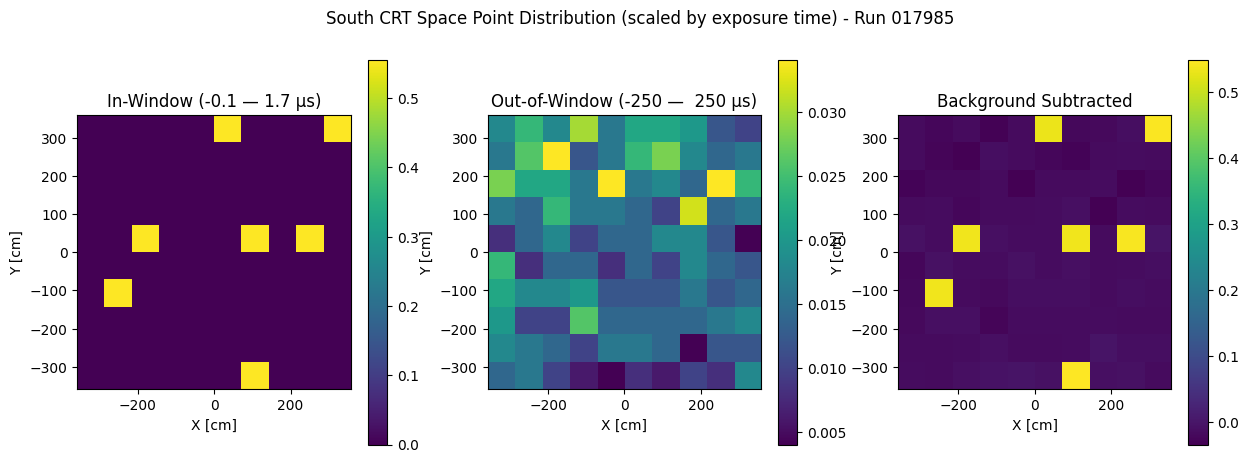

In [14]:
crt_offset = 1
wall_to_plot = 1
plot_sp_coord_wall(relative_ts0, filter_spx, filter_spy, filter_spz, wall_tag, run, plot_wall=wall_to_plot, interval_in=(-0.1, 1.7), interval_out=(-250, 250), offset=crt_offset, check_interval=False, bins=10)